# Creating statistics and maps of street designations for communes

## Load libraries and data

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

%matplotlib inline

In [2]:
# Street name designations
streetnames = pd.read_csv('../Datapreparation/streetnames.csv', encoding='UTF-8-SIG', sep=';')

# Communes data
com = pd.read_csv('data/gmde_info.csv', encoding='UTF-8-SIG', sep=';')

# Communes geometries
com_geom = geopandas.read_file('data/gemeinden.geojson')

## Merging datasets

In [3]:
# Create dataset with all information on commune level
communes = pd.merge(com_geom, com, on=['GMDNR'], how='outer')

In [4]:
#get most common generic street designation per commune
commune_top_term = streetnames.groupby(['COM_FOSNR'])['STR_TERMS'].agg(pd.Series.mode).to_frame()

In [5]:
commune_top_term.STR_TERMS.apply(lambda x: str(x)).unique()

array(['weg', 'strasse', 'wäg', "['strasse' 'weg']", '[]', 'chemin',
       'rue', 'route', "['chemin' 'rue']", "['gasse' 'weg']",
       "['impasse' 'route']", 'impasse', "['chemin' 'route']", 'gasse',
       'platz', 'voa', 'voia', 'veia', 'via', 'vietta', 'strada',
       'ruelle', "['chemin' 'route' 'rue']", "['route' 'rue']",
       "['chemin' 'gasse' 'route' 'rue' 'ruelle']"], dtype=object)

In [6]:
#There are multiple mode for some communes, we only keep the first one.
commune_top_term['STR_TERMS'] = commune_top_term['STR_TERMS'].str.replace("(' ').*","", regex=True)

In [7]:
commune_top_term.STR_TERMS.apply(lambda x: str(x)).unique()

array(['weg', 'strasse', 'wäg', 'nan', 'chemin', 'rue', 'route',
       'impasse', 'gasse', 'platz', 'voa', 'voia', 'veia', 'via',
       'vietta', 'strada', 'ruelle'], dtype=object)

In [8]:
communes = pd.merge(communes, commune_top_term, left_on='GMDNR', right_on='COM_FOSNR', how='outer')

In [9]:
communes.columns

Index(['FID', 'GMDHISTID_x', 'GMDNR', 'GMDNAME_x', 'BZHISTID_x', 'BZNR_x',
       'KTNR_x', 'GRNR_x', 'AREA_HA_x', 'E_MIN', 'E_MAX', 'N_MIN', 'N_MAX',
       'E_CNTR_x', 'N_CNTR_x', 'Z_MIN', 'Z_MAX', 'Z_AVG', 'Z_MED', 'Z_CNTR_x',
       'geometry', 'GMDHISTID_y', 'GMDNAME_y', 'BZHISTID_y', 'BZNR_y',
       'KTNR_y', 'GRNR_y', 'AREA_HA_y', 'E_CNTR_y', 'N_CNTR_y', 'Z_CNTR_y',
       'GMD_STR_LENGTH', 'STR_TERMS'],
      dtype='object')

## Mapping most common street term per commune

<AxesSubplot: >

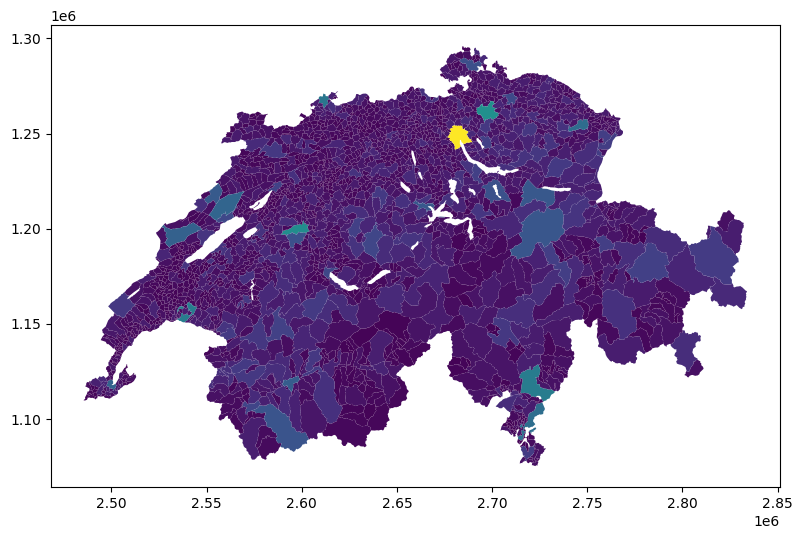

In [10]:
communes.plot(column='GMD_STR_LENGTH', figsize=(10, 6))

In [11]:
communes['STR_TERMS'] = communes['STR_TERMS'].fillna('other')

In [12]:
communes['STR_TERMS'].apply(lambda x: str(x)).unique()

array(['strasse', 'via', 'weg', 'wäg', 'other', 'chemin', 'rue', 'route',
       'impasse', 'gasse', 'platz', 'voa', 'voia', 'veia', 'vietta',
       'strada', 'ruelle'], dtype=object)

In [13]:
colors = {
    'chemin': '#cab2d6',
    'gasse': '#1f78b4',
    'impasse': '#e31a1c',
    'platz': '#35978f',
    'route': '#fb9a99',
    'rue': '#b2df8a',
    'ruelle': '#33a02c',
    'strada': '#ffff33',
    'strasse': '#a6cee3',
    'veia': '#f1b6da',
    'via': '#fee08b',
    'vietta': '#762a83',
    'voa': '#c51b7d',
    'voia': '#8c510a',
    'wäg': '#ff7f00',
    'weg': '#fdbf6f',
    'other': '#d9d9d9',
}

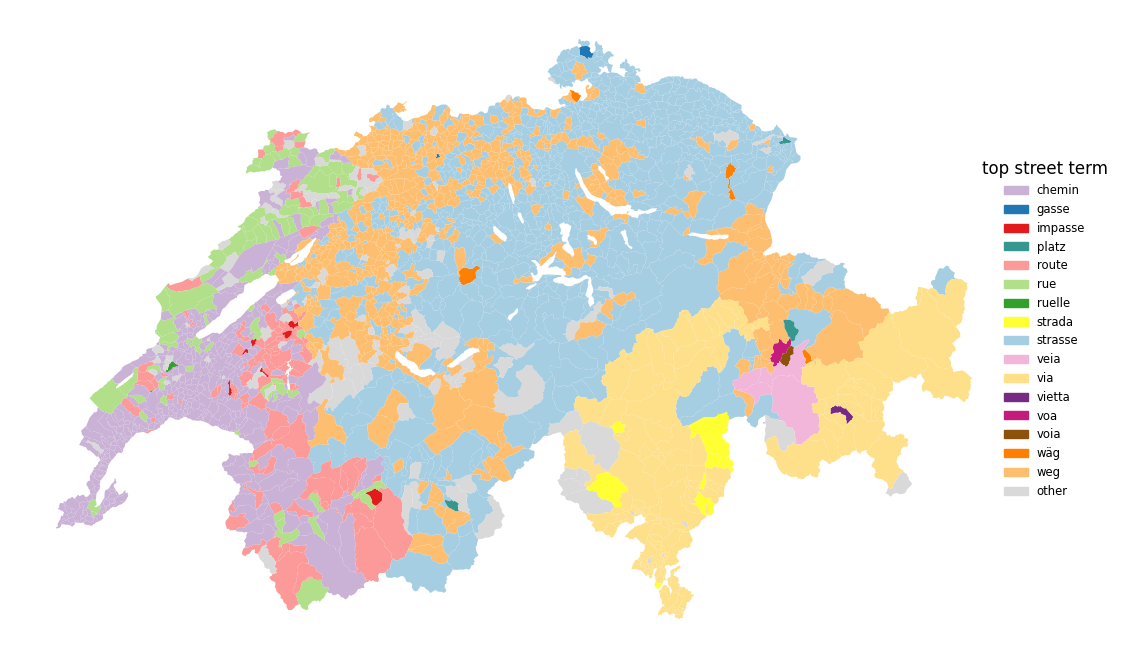

In [29]:
f, ax = plt.subplots(1, figsize=(13,13))
    
    
communes.plot(ax=ax, 
                        color=[colors[d] for d in communes.STR_TERMS])


plt.axis('off')

plt.legend(handles=[mpatches.Patch(color=colors[k],
                label=k) for k in colors],
               loc='center right',
               fontsize='small',
               edgecolor='none',
               title='top street term',
               title_fontsize='large',
               bbox_to_anchor=(1.1, 0.5))

## Mapping ratio of named streets (vs streets without name)

In [16]:
# Street name geometries
streets_geom = geopandas.read_file('data/pure_line.geojson')

In [17]:
# Create dataset with all information on street level
streetnames_geom = pd.merge(streets_geom, streetnames, on=['STR_ESID','STR_ESID'], how='outer')

In [18]:
streetnames_length_comm = streetnames_geom.dissolve(by='COM_FOSNR', aggfunc={
         "LENGTH": "sum",
         "COM_NAME": "first",
         "COM_FOSNR": "first"    
     })

In [19]:
streetnames_length_comm.columns

Index(['geometry', 'LENGTH', 'COM_NAME', 'COM_FOSNR'], dtype='object')

In [20]:
# to remove ambiguity error
streetnames_length_comm.rename(columns = {'COM_FOSNR':'FOSNR'}, inplace = True)

In [21]:
#now we have per commune street length AND streetname length
communes_length = pd.merge(communes, streetnames_length_comm, left_on='GMDNR', right_on='COM_FOSNR', how='outer')

In [22]:
communes_length.LENGTH = communes_length.LENGTH/1000

In [23]:
communes_length = communes_length.assign(ratioNamed = communes_length.LENGTH/communes_length.GMD_STR_LENGTH)

In [24]:
# to remove ambiguity error
communes_length.rename(columns = {'geometry_x':'geometry'}, inplace = True)

In [25]:
communes_length['ratioNamed'] = communes_length['ratioNamed'].fillna('0')

In [26]:
communes_length['ratioNamed'] = communes_length['ratioNamed'].astype(str).astype(float)

(2468003.35, 2851257.65, 1064234.8020000015, 1306970.712999999)

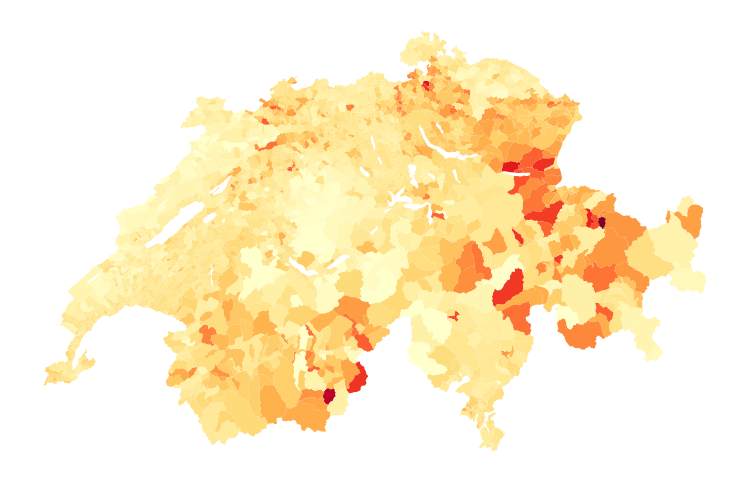

In [27]:
communes_length.plot(column='ratioNamed', cmap='YlOrRd', figsize=(10, 6))
plt.axis('off')

(2468003.35, 2851257.65, 1064234.8020000015, 1306970.712999999)

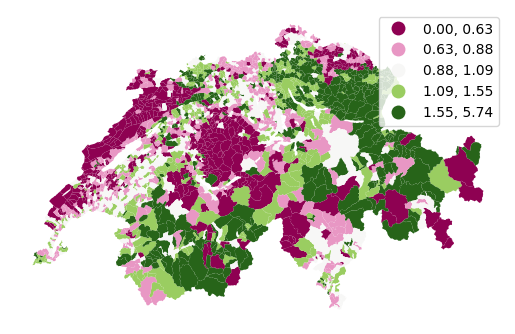

In [28]:
fig, ax = plt.subplots(1, 1)
communes_length.plot(column='ratioNamed', 
                     cmap='PiYG', 
                     figsize=(113,13), 
                     ax=ax, 
                     legend=True,
                     scheme='quantiles')
plt.axis('off')